In [1]:
from mintpy.utils import *
import mintpy.utils as mpu
import mintpy.utils.readfile
import mintpy.utils.utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [2]:
sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")
# sns.set_theme(style="white") #, font_scale=0.5)
plt.style.use(['seaborn-paper', 'seaborn-ticks'])
sns.set_color_codes()

In [3]:
matplotlib.rcParams['lines.linewidth']
matplotlib.rcParams['axes.linewidth']
plt.style.available
matplotlib.use("pgf")
matplotlib.rcParams.update({    
    'font.family': 'serif',
    'font.serif': [],       # use latex default serif font
    'font.sans-serif': [],  # use a specific sans-serif font
    'font.monospace': [],   # use a specific sans-serif font
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'pdflatex',
    'lines.linewidth': 0.7,
    'axes.linewidth': 0.6,
    'axes.unicode_minus': False
})

golden_ratio = (5**.5 - 1) / 2

width  = 3.48761
height = width*golden_ratio
print(width,height)

3.48761 2.155461519504021


In [4]:
mask_data, mask_attr = mpu.readfile.read('/data1/data/sar_isb_dumps/mintpy/maskROI.h5')

In [5]:
plt.imshow(mask_data)

In [6]:
mask_data_temp, mask_attr_temp = mpu.readfile.read('/data1/data/sar_isb_dumps/mintpy/_Isc/maskTempCoh.h5')
plt.imshow(mask_data_temp)

In [7]:
plt.imshow(mask_data*mask_data_temp)
mask_data = mask_data*mask_data_temp

In [8]:
ts_file = '/data1/data/sar_isb_dumps/mintpy/_Isc/timeseries_ERA5_ramp_demErr.h5'

In [9]:
ts_data, ts_attr = mpu.readfile.read(ts_file)

In [10]:
from mintpy.objects import (
    geometryDatasetNames,
    geometry,
    ifgramStack,
    timeseries,
)
from mintpy.utils import ptime, readfile

In [11]:
obj = timeseries(ts_file)

In [12]:
date_list = timeseries(ts_file).get_date_list()

In [13]:
the_dates, dis = mpu.utils.read_timeseries_yx(0,0, ts_file=ts_file)

input y / x: 0 / 0


In [14]:
ts_attr

{'ALOOKS': '2',
 'ANTENNA_SIDE': '-1',
 'AZIMUTH_PIXEL_SIZE': '36.90020546733459',
 'CENTER_LINE_UTC': '14734.0',
 'DATA_TYPE': 'float32',
 'DATE12': '171204-180202',
 'EARTH_RADIUS': '6368718.889498402',
 'END_DATE': '20201224',
 'FILE_LENGTH': '1107',
 'FILE_PATH': '/data1/data/sar_isb_dumps/mintpy/_Isc/timeseries_ERA5_ramp_demErr.h5',
 'FILE_TYPE': 'timeseries',
 'HEADING': '-1.664352959066593e+02',
 'HEIGHT': '701284.8644845383',
 'INCIDENCE_ANGLE': '3.910847785139392e+01',
 'LAT_REF1': '41.0716219233434',
 'LAT_REF2': '41.2167943098809',
 'LAT_REF3': '40.90606367448475',
 'LAT_REF4': '41.05126523100622',
 'LENGTH': '37',
 'LONG_REF1': '30.39682612423794',
 'LONG_REF2': '29.29556944192746',
 'LONG_REF3': '30.3567438684797',
 'LONG_REF4': '29.25834460312059',
 'ORBIT_DIRECTION': 'DESCENDING',
 'PLATFORM': 'sen',
 'PRF': '1717.128973878037',
 'PROCESSOR': 'snap',
 'PROJECT_NAME': 'mintpy',
 'P_BASELINE_BOTTOM_HDR': '9.704228401184082',
 'P_BASELINE_TOP_HDR': '9.704228401184082',
 'RA

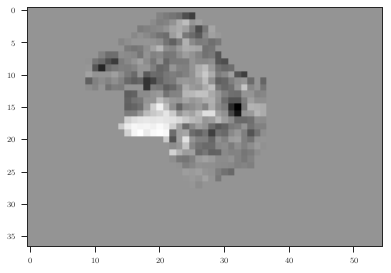

In [15]:
fig = plt.figure()
plt.imshow(ts_data[1]*mask_data);
fig

In [16]:
ts_cum_sum = (ts_data*mask_data).sum(axis=(1,2))/mask_data.sum()
ts_cum_sum.shape

(91,)

In [17]:
df_ts_data = pd.DataFrame(ts_cum_sum, columns=['Displacement'], index=pd.DatetimeIndex(the_dates))

In [18]:
df_ts_data = df_ts_data.resample('12D').mean().rename(columns=lambda x: 'Displacement')

In [19]:
try:
    a = open('/data1/data/sar_isb_dumps/mintpy/_Isc/exclude_date.txt').readlines()
except:
    a = []
# a.append('20191112\n') #Missing data from S1
# a.append('20191230\n')
a

[]

In [20]:
excludeDate = [x[:-1] for x in a]

In [21]:
df_ts_data['Count'] = 1

In [22]:
for i in excludeDate:
    df_ts_data.loc[i[:8]:i[:8]] = 0

In [23]:
df_ts_data['Days'] = 1

In [24]:
df_ts_data.Displacement *= 100
# df_ts_data.Displacement /= 12

In [25]:
df_ts_B = pd.DataFrame(ts_cum_sum, columns=['Displacement'], index=pd.DatetimeIndex(the_dates))
df_ts_B.loc[excludeDate, 'Displacement'] = np.nan
df_ts_B  = df_ts_B['2018-01-01':]
df_ts_B.Displacement *= 100
# df_ts_B.Displacement /= 12
df_ts_B

,Displacement
2018-01-09,0.100379
2018-01-21,0.066796
2018-02-02,0.102420
2018-02-14,0.060805
2018-02-26,0.049009
...,...
2020-11-06,2.096957
2020-11-18,2.083008
2020-11-30,1.907470
2020-12-12,1.974626


In [26]:
df_ts_A = df_ts_data.copy()
df_ts_A.loc[excludeDate, 'Displacement'] = np.nan
df_ts_A = df_ts_A.resample('D').last()
df_ts_A.Displacement = df_ts_A.Displacement.interpolate(method='linear').diff()
df_ts_A = df_ts_A.bfill(limit=11) \
                 .resample('A') \
                 .sum()
df_ts_A['Velocity'] = df_ts_A.Displacement/df_ts_A.Days*365.25
df_ts_A.Displacement = (df_ts_A.Displacement).cumsum()
# df_ts_A.Velocity = df_ts_A.Velocity/df_ts_A.Days*365.25
df_ts_A = df_ts_A['2018-01-01':]
df_ts_A

,Displacement,Count,Days,Velocity
2018-12-31,0.980772,365.0,365.0,0.947961
2019-12-31,1.918759,365.0,365.0,0.938629
2020-12-31,2.043294,359.0,359.0,0.126703


In [27]:
df_ts_Q = df_ts_data.copy()
df_ts_Q.loc[excludeDate, 'Displacement'] = np.nan
df_ts_Q = df_ts_Q.resample('D').last()
df_ts_Q.Displacement = df_ts_Q.Displacement.interpolate(method='linear').diff()
df_ts_Q = df_ts_Q.bfill(limit=11) \
                 .resample('Q') \
                 .sum()
df_ts_Q['Velocity']  = df_ts_Q.Displacement/df_ts_Q.Days*365.25
df_ts_Q.Displacement = df_ts_Q.Displacement.cumsum()
df_ts_Q = df_ts_Q
df_ts_Q

,Displacement,Count,Days,Velocity
2017-12-31,0.033460,4.0,4.0,3.055278
2018-03-31,0.245581,90.0,90.0,0.860861
2018-06-30,0.682109,91.0,91.0,1.752106
2018-09-30,0.801848,92.0,92.0,0.475377
2018-12-31,0.980772,92.0,92.0,0.710346
2019-03-31,1.004919,90.0,90.0,0.097999
2019-06-30,1.285276,91.0,91.0,1.125278
2019-09-30,1.418781,92.0,92.0,0.530028
2019-12-31,1.918759,92.0,92.0,1.984967
2020-03-31,1.673379,91.0,91.0,-0.984889


In [28]:
df_ts_M = df_ts_data.copy()
df_ts_M.loc[excludeDate, 'Displacement'] = np.nan
df_ts_M = df_ts_M.resample('D').last()
df_ts_M.Displacement = df_ts_M.Displacement.interpolate(method='linear').diff()
df_ts_M = df_ts_M.bfill(limit=11) \
                 .resample('M') \
                 .sum()
df_ts_M['Velocity']  = df_ts_M.Displacement/df_ts_M.Days*365.25
df_ts_M.Displacement = df_ts_M.Displacement.cumsum()
df_ts_M = df_ts_M['2018-01-01':]
df_ts_M

,Displacement,Count,Days,Velocity
2018-01-31,0.104848,31.0,31.0,0.841116
2018-02-28,0.119640,28.0,28.0,0.192959
2018-03-31,0.245581,31.0,31.0,1.483873
2018-04-30,0.488751,30.0,30.0,2.960585
2018-05-31,0.451496,31.0,31.0,-0.438939
2018-06-30,0.682109,30.0,30.0,2.807708
2018-07-31,0.634375,31.0,31.0,-0.562412
2018-08-31,0.993242,31.0,31.0,4.228267
2018-09-30,0.801848,30.0,30.0,-2.330228
2018-10-31,0.679033,31.0,31.0,-1.447038


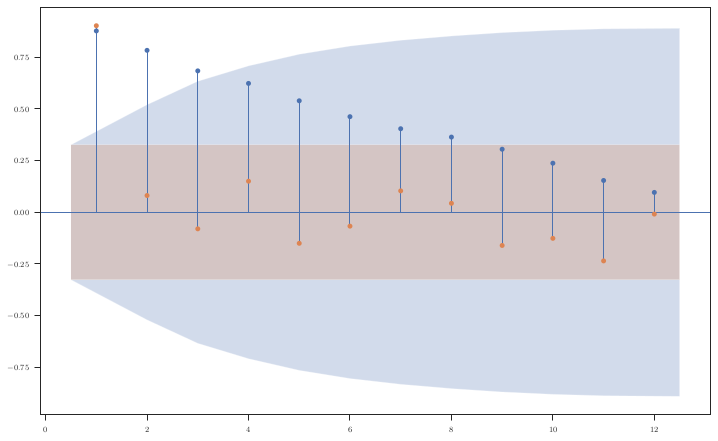

In [29]:
fig = plt.figure(figsize=(12,7.5))
ax = fig.subplots()
plot_acf(df_ts_M.Displacement, zero=False, ax=ax, lags=12)
plot_pacf(df_ts_M.Displacement, zero=False, ax=ax, lags=12)
ax.set_title(None)
fig

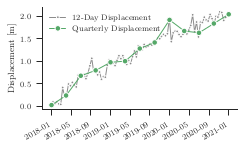

In [30]:
fig = plt.figure(figsize=(width,height))
ax1 = fig.subplots()
sns.lineplot(data=df_ts_B.Displacement, marker='.', color='C7', ax=ax1);
sns.lineplot(data=df_ts_Q.Displacement, marker='o', color='C2', ax=ax1)
ax1.set_ylabel(r'Displacement [m]')
plt.legend(ax1.lines,["12-Day Displacement"]+["Quarterly Displacement"], loc='upper left')
sns.despine(right=True, trim=False)
fig.autofmt_xdate()
# ax1.set_xlabel(None)
# ax1.set_xticklabels([])
# ax1.text(1.0,0.05,'Istanbul',
#         horizontalalignment='right',
#         verticalalignment='bottom',
#         transform=ax1.transAxes)
fig.tight_layout()
fig.savefig("pgf/isb_displacement_velocity.pgf", backend='pgf', dpi=600)
fig

In [31]:
stringency = pd.read_csv("/data1/data/stringency_index.csv", index_col=1, parse_dates=True, )
stringency = stringency.T
stringency = stringency[2:] 
stringency.index = pd.DatetimeIndex(stringency.index)

In [32]:
STR = stringency['TUR'].astype(float)
df_ts_Q['Stringency'] = STR.resample('Q') \
                           .mean()['2018-01-01':] 
df_ts_Q['Stringency'].fillna(0, inplace=True)

In [33]:
STR = stringency['TUR'].astype(float)
df_ts_M['Stringency'] = STR.resample('M') \
                           .mean()['2018-01-01':] 
df_ts_M['Stringency'].fillna(0, inplace=True)

In [34]:
country = "Turkey_Seasonal"
GDP = pd.read_csv("/data1/data/GDP.csv" )
GDP.index = pd.DatetimeIndex(GDP.Date)
GDP = GDP.resample('Q').max()
df_ts_Q.loc[:, "GDP"] = GDP[country]

GDP_M = (GDP[country]).resample('M').last()
GDP_M['2020-10-31'] = np.NaN
GDP_M['2020-11-30'] = np.NaN
GDP_M['2020-12-31'] = np.NaN

GDP_Q = GDP[country]

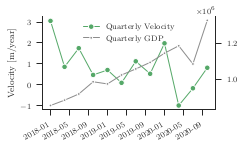

In [35]:
fig = plt.figure(figsize=(width,height))
ax1 = sns.lineplot(data=df_ts_Q.Velocity.loc[:'2020-09-30'], marker='o', color='C2');
ax1.set_ylabel(r'Velocity [m/year]')
# ax1.set_ylabel(None)
ax2 = plt.twinx()
sns.lineplot(data=df_ts_Q.GDP, ax=ax2, marker='.', color='C7')
# ax2.set_ylabel(r'GDP [\textcurrency]')
ax2.set_ylabel(None)
ax2.set_ylim(top=1350000)
plt.legend(ax1.lines+ax2.lines, ["Quarterly Velocity"]+["Quarterly GDP"], loc='upper center')
sns.despine(right=False, trim=False);
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig("pgf/isb_acceleration.pgf", backend='pgf', dpi=600)
fig

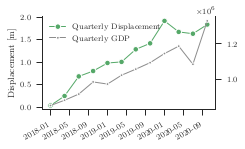

In [36]:
fig = plt.figure(figsize=(width,height))
ax1 = sns.lineplot(data=df_ts_Q.Displacement.loc[:'2020-09-30'], marker='o', color='C2')
ax1.set_ylabel(r'Displacement [m]')
ax2 = plt.twinx()
sns.lineplot(data=df_ts_Q.GDP, ax=ax2, marker='.', color='C7')
# ax2.set_ylabel(r'GDP [\textcurrency]')
ax2.set_ylabel(None)
plt.legend(ax1.lines+ax2.lines, ["Quarterly Displacement"]+["Quarterly GDP"], loc='upper left')
sns.despine(right=False, trim=False);
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig("pgf/isb_velocity_GDP.pgf", backend='pgf', dpi=600)
fig

In [37]:
df_ts_M['GDP_naive']      = (df_ts_Q.GDP).resample('M').last()
df_ts_M.GDP_naive         =  df_ts_M.GDP_naive.bfill()
df_ts_M['GDP'] = GDP_M.reset_index() \
                      .interpolate(method='spline', order=3) \
                      .set_index('Date') \
                      .shift(-1)[:'2020-09-30']
df_ts_M 

,Displacement,Count,Days,Velocity,Stringency,GDP_naive,GDP
2018-01-31,0.104848,31.0,31.0,0.841116,0.000000,882477.0,8.751346e+05
2018-02-28,0.119640,28.0,28.0,0.192959,0.000000,882477.0,8.824770e+05
2018-03-31,0.245581,31.0,31.0,1.483873,0.000000,882477.0,8.895201e+05
2018-04-30,0.488751,30.0,30.0,2.960585,0.000000,917009.0,8.997366e+05
2018-05-31,0.451496,31.0,31.0,-0.438939,0.000000,917009.0,9.170090e+05
2018-06-30,0.682109,30.0,30.0,2.807708,0.000000,917009.0,9.428324e+05
2018-07-31,0.634375,31.0,31.0,-0.562412,0.000000,985413.0,9.691236e+05
2018-08-31,0.993242,31.0,31.0,4.228267,0.000000,985413.0,9.854130e+05
2018-09-30,0.801848,30.0,30.0,-2.330228,0.000000,985413.0,9.850711e+05
2018-10-31,0.679033,31.0,31.0,-1.447038,0.000000,973417.0,9.768689e+05


In [38]:
dates_prior = slice('2018-01-01','2019-12-31')
dates_full = slice('2018-01-01','2020-08-31')

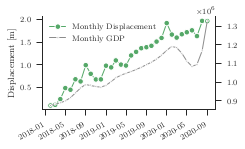

In [39]:
fig = plt.figure(figsize=(width,height))
ax1 = sns.lineplot(data=df_ts_M.Displacement.loc[dates_full], marker='o', color='C2')
ax1.set_ylabel(r'Displacement [m]')
ax2 = plt.twinx()
# sns.lineplot(data=df_ts_M.GDP_naive.loc[dates_full], ax=ax2, marker='.', color='C1')
sns.lineplot(data=df_ts_M.GDP.loc[dates_full], ax=ax2, marker='.', markersize=4, color='C7')
# ax2.set_ylabel(r'GDP [\textcurrency]')
ax2.set_ylabel(None)
# ax2.set_ylim(top=1350000)
plt.legend(ax1.lines+ax2.lines, ["Monthly Displacement"]+["Monthly GDP"], loc='upper left')
sns.despine(right=False, trim=False);
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig("pgf/isb_velocity_GDP_monthly.pgf", backend='pgf', dpi=600)
fig

In [40]:
import statsmodels.api as sm
X_var = ['GDP']
dates = slice('2018-01-31','2019-12-31')
X = df_ts_M.loc[dates_prior, X_var]
y = df_ts_M.Displacement[dates_prior]
X = sm.add_constant(X)
# X['trend'] = range(1,len(X)+1)
# Note the difference in argument order
model = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':12})
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Displacement   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     1326.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           3.71e-21
Time:                        12:52:53   Log-Likelihood:                 22.456
No. Observations:                  24   AIC:                            -40.91
Df Residuals:                      22   BIC:                            -38.56
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5475      0.155    -29.346      0.000      -4.851      -4.244
GDP         5.433e-06   1.49e-07     36.412      0.000    5.14e-06    5.73e-06
==============================================================================
Omnibus:                        1.330   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.514   Jarque-Bera (JB):                1.194
Skew:                           0.407   Prob(JB):                        0.550
Kurtosis:                       2.271   Cond. No.                     1.23e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
[2] The condition number is large, 1.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
import statsmodels.api as sm
X_var = ['GDP']
X = df_ts_M.loc[dates_full, X_var]
y = df_ts_M.Displacement[dates_full]
X = sm.add_constant(X)
# X['trend'] = range(1,len(X)+1)
# Note the difference in argument order
model = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':12})
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Displacement   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     153.8
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           2.44e-13
Time:                        12:52:53   Log-Likelihood:                 9.5499
No. Observations:                  32   AIC:                            -15.10
Df Residuals:                      30   BIC:                            -12.17
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8963      0.423     -9.213      0.000      -4.725      -3.067
GDP         4.804e-06   3.87e-07     12.402      0.000    4.04e-06    5.56e-06
==============================================================================
Omnibus:                        3.154   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                2.056
Skew:                          -0.173   Prob(JB):                        0.358
Kurtosis:                       4.193   Cond. No.                     1.06e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
[2] The condition number is large, 1.06e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
import statsmodels.api as sm
X_var = ['GDP','Stringency']
X = df_ts_M.loc[dates_full, X_var].copy()
X.GDP /= 1000000
y = df_ts_M.Displacement[dates_full]
X = sm.add_constant(X)
# X['trend'] = range(0,len(X))
# Note the difference in argument order
model = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':12})
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Displacement   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     155.5
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           3.16e-16
Time:                        13:31:04   Log-Likelihood:                 13.494
No. Observations:                  32   AIC:                            -20.99
Df Residuals:                      29   BIC:                            -16.59
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5058      0.593     -5.908      0.000      -4.669      -2.343
GDP            4.3871      0.576      7.615      0.000       3.258       5.516
Stringency     0.0039      0.001      3.159      0.002       0.001       0.006
==============================================================================
Omnibus:                       13.529   Durbin-Watson:                   1.326
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.037
Skew:                          -1.176   Prob(JB):                     0.000543
Kurtosis:                       5.397   Cond. No.                         416.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
"""

In [58]:
print("GDP", X.GDP.min(), X.GDP.max())
print("Displacement", X.GDP.min()*4.3871, X.GDP.max()*4.3871)
print("Stringency", X.Stringency.min(), X.Stringency.max())
print("Stringency", X.Stringency.min()*0.0039, X.Stringency.max()*0.0039)

GDP 0.8751346109211724 1.32915
Displacement 3.8393030515722755 5.831113965
Stringency 0.0 76.17666666666668
Stringency 0.0 0.29708900000000005


In [43]:
'{:.20f}'.format(4.387e-06)

'0.00000438700000000000'

In [52]:
import statsmodels.api as sm
X_var = ['GDP','Stringency']
dates = slice('2018-03-31','2020-09-30')
X = df_ts_Q.loc[dates, X_var]
y = df_ts_Q.Displacement[dates]
X = sm.add_constant(X)
# X['trend'] = range(1,len(X)+1)
# Note the difference in argument order
model = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':4})
X_all = df_ts_Q.loc[dates, X_var]
X_all.Stringency = 0.0
X_all = sm.add_constant(X_all)
# X_all['trend'] = range(1,len(X)+1)
predictions = model.predict(X_all) # make the predictions by the model
# Print out the statistics
model.summary()

/home/tvanzyl/anaconda3/envs/mintpy/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Displacement   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     23.07
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           0.000477
Time:                        13:30:32   Log-Likelihood:                 1.0091
No. Observations:                  11   AIC:                             3.982
Df Residuals:                       8   BIC:                             5.176
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6936      0.906     -2.973      0.003      -4.470      -0.918
GDP         3.688e-06   8.72e-07      4.229      0.000    1.98e-06     5.4e-06
Stringency     0.0003      0.003      0.116      0.908      -0.005       0.005
==============================================================================
Omnibus:                        0.018   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.991   Jarque-Bera (JB):                0.144
Skew:                          -0.027   Prob(JB):                        0.931
Kurtosis:                       2.442   Cond. No.                     1.10e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
[2] The condition number is large, 1.1e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
df_ts_Q["Prediction"] = predictions
df_ts_Q["Residual_Displacement"] = (df_ts_Q.Displacement-df_ts_Q.Prediction)

In [46]:
df_ts_Q.loc['20180101':'20191231',['Velocity','Displacement','GDP','Residual_Displacement']].corr()

,Velocity,Displacement,GDP,Residual_Displacement
Velocity,1.000000,0.319687,0.147049,0.556733
Displacement,0.319687,1.000000,0.971883,0.927206
GDP,0.147049,0.971883,1.000000,0.812943
Residual_Displacement,0.556733,0.927206,0.812943,1.000000


In [47]:
df_ts_Q.loc['20180101':'20200930',['Velocity','Displacement','GDP','Residual_Displacement','Stringency']].corr()

,Velocity,Displacement,GDP,Residual_Displacement,Stringency
Velocity,1.000000,-0.147909,-0.225772,0.121841,-0.384223
Displacement,-0.147909,1.000000,0.899406,0.454205,0.529262
GDP,-0.225772,0.899406,1.000000,0.019090,0.577757
Residual_Displacement,0.121841,0.454205,0.019090,1.000000,0.033042
Stringency,-0.384223,0.529262,0.577757,0.033042,1.000000


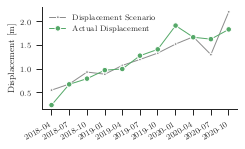

In [48]:
fig = plt.figure(figsize=(width,height))
ax = sns.lineplot(data=df_ts_Q.Prediction, marker='.', color='C7')
sns.lineplot(data=df_ts_Q.Displacement.loc[dates], marker='o', color='C2', ax=ax)
ax.set_ylabel(r'Displacement [m]')
plt.legend(["Displacement  Scenario","Actual Displacement"], loc='upper left')
sns.despine(trim=False);
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig("pgf/isb_scenario_velocity.pgf", backend='pgf', dpi=600)
fig

In [49]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
model = AutoReg(df_ts_M.loc[:'20200731','Displacement'], lags=1, trend='t', exog=df_ts_M.loc[:'20200731',['Stringency','GDP']])
# model = ARIMA(df_ts_M.loc[:'20200630','Velocity'], order=(1,0,0), exog=df_ts_M.loc[:'20200630',['Stringency','GDP']])
res = model.fit()
print(res.summary())
pred_res = res.get_prediction(start='20180131', end='20200930', exog_oos=df_ts_M.loc['20200830':'20200930',['Stringency','GDP']])
# pred_res = res.get_prediction(start='20180131', end='20200930', exog=df_ts_M.loc['20200731':'20200930',['Stringency','GDP']])
P = pred_res.conf_int()[dates]
P['mean'] = pred_res.predicted_mean[dates]
PP = P.unstack().rename('Displacement').to_frame().reset_index()

                            AutoReg Model Results                             
Dep. Variable:           Displacement   No. Observations:                   31
Model:                   AutoReg-X(1)   Log Likelihood                  22.502
Method:               Conditional MLE   S.D. of innovations              0.114
Date:                Fri, 04 Jun 2021   AIC                             -4.005
Time:                        12:52:53   BIC                             -3.771
Sample:                    02-28-2018   HQIC                            -3.930
                         - 07-31-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
trend               0.0511      0.012      4.371      0.000       0.028       0.074
Displacement.L1     0.1241      0.178      0.695      0.487      -0.226       0.474
Stringency         -0.0025      

/home/tvanzyl/anaconda3/envs/mintpy/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


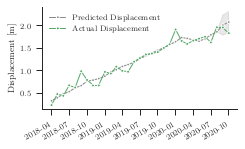

In [50]:
fig = plt.figure(figsize=(width,height))
ax = sns.lineplot(data=PP, x='level_1', y='Displacement',  marker='.', color='C7')
ax.set_xlabel(None)
sns.lineplot(data=df_ts_M.Displacement.loc[dates], marker='o', markersize=3, color='C2', ax=ax)
ax.set_ylabel(r'Displacement [m]')
plt.legend(["Predicted Displacement","Actual Displacement"], loc='upper left')
sns.despine(trim=False);
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig("pgf/isb_predicted_velocity.pgf", backend='pgf', dpi=600)
fig